<a href="https://colab.research.google.com/github/janvikna/BDA/blob/main/Project_eda_on_instacart_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Exploiting the power of data analysis to take business to the next level!
> ## [You can find here the Business Questions and Solutions extracted from the insights in this notebook](http://drive.google.com/file/d/1dScC6CcaUfHFnJkTnOfDsiRH_bwtOYT6/view?usp=sharing)

## Importing needed libraries

In [4]:
import numpy as np
import pandas as pd
import os
import zipfile
import glob
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
from IPython.display import display
import random

# define Seaborn color palette to use
# colors = sns.color_palette("hls", 8)
colors = sns.color_palette("crest", 8)
cmap_colors = sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True)

# define the fig size of all figures
plt.rcParams["figure.figsize"] = (10,6)
# the directory to unzip the data in
data_directory_path = '/kaggle/working/dataset/'

# Converting the days and hours from numbers to their interpretable form
days_of_week = {0: 'Saturday',
                1: 'Sunday',
                2: 'Monday',
                3: 'Tuesday',
                4: 'Wednesday',
                5: 'Thursday',
                6: 'Friday'}
hour_nums = list(range(24))
hours_of_day = {hour_num:datetime.time(hour_num).strftime("%I:00 %p") for hour_num in hour_nums}

In [5]:
# Unziping all dataset tables. Placing unzipped files in /kaggle/working/dataset directory

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        with zipfile.ZipFile(os.path.join(dirname, filename), 'r') as zip_ref:
            zip_ref.extractall(data_directory_path)

In [6]:
'''
    iterate through all the columns of a dataframe and modify the data type
    to reduce memory usage.
'''
def reduce_mem_usage(train_data):
    start_mem = train_data.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in train_data.columns:
        col_type = train_data[col].dtype

        if col_type not in [object, 'category']:
            c_min = train_data[col].min()
            c_max = train_data[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    train_data[col] = train_data[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    train_data[col] = train_data[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    train_data[col] = train_data[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    train_data[col] = train_data[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    train_data[col] = train_data[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    train_data[col] = train_data[col].astype(np.float32)
                else:
                    train_data[col] = train_data[col].astype(np.float64)
        else:
            train_data[col] = train_data[col].astype('category')
    end_mem = train_data.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return train_data

# Annotate text on graph
def annotate_text(p, append_to_text='%'):
    for p in ax.patches:
        txt = str(p.get_height().round(2)) + append_to_text
        txt_x = p.get_x() + p.get_width()/2.
        txt_y = 0.92*p.get_height()
        ax.text(txt_x,txt_y,txt, fontsize=20, color='#004235', ha='center', va='bottom')

## Reading The Data

In [11]:
# Reading the csv files into corresponding dataframes
# Then reduce their size to consume less memory
aisles = pd.read_csv('/content/sample_data/aisles.csv')
aisles = reduce_mem_usage(aisles)

departments = pd.read_csv('/content/sample_data/departments.csv')
departments = reduce_mem_usage(departments)

order_products_prior = pd.read_csv('/content/sample_data/order_products__prior.csv')
order_products_prior = reduce_mem_usage(order_products_prior)

order_products_train = pd.read_csv('/content/sample_data/order_products__train.csv')
order_products_train = reduce_mem_usage(order_products_train)

orders = pd.read_csv('/content/sample_data/orders.csv')
# Replacing numbers with their corresponding hour representation
orders['order_hour_of_day'] = np.where(orders['order_hour_of_day'].isin(hours_of_day), None, orders['order_hour_of_day'])
#orders['order_hour_of_day'] = orders['order_hour_of_day'].replace(to_replace=hours_of_day, value=None)
orders['order_hour_of_day'] = pd.Categorical(orders['order_hour_of_day'],
                                             ordered=True,
                                             categories=list(hours_of_day.values()))
# Replacing numbers with their corresponding day of week
# Define the categories of days of week sorted normally from Saturday to Friday
#orders['order_dow'] = orders['order_dow'].replace(to_replace=days_of_week, value=None)
orders['order_dow'] = np.where(orders['order_dow'].isin(days_of_week), None, orders['order_dow'])
orders['order_dow'] = pd.Categorical(orders['order_dow'],
                                     ordered=True,
                                     categories=list(days_of_week.values()))
orders = reduce_mem_usage(orders)

products = pd.read_csv('/content/sample_data/products.csv')
products = reduce_mem_usage(products)

Memory usage of dataframe is 0.00 MB
Memory usage after optimization is: 0.01 MB
Decreased by -159.9%
Memory usage of dataframe is 0.00 MB
Memory usage after optimization is: 0.00 MB
Decreased by -92.7%
Memory usage of dataframe is 39.23 MB
Memory usage after optimization is: 12.26 MB
Decreased by 68.7%
Memory usage of dataframe is 37.78 MB
Memory usage after optimization is: 11.81 MB
Decreased by 68.7%
Memory usage of dataframe is 8.26 MB
Memory usage after optimization is: 2.56 MB
Decreased by 69.0%
Memory usage of dataframe is 1.52 MB
Memory usage after optimization is: 1.91 MB
Decreased by -25.8%


## Understading Data

In [12]:
print('Shape of order_products_train table: ', order_products_train.shape)
order_products_train.head(10)

Shape of order_products_train table:  (1238070, 4)


,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1
5,1,13176,6,0
6,1,47209,7,0
7,1,22035,8,1
8,36,39612,1,0
9,36,19660,2,1


In [13]:
print('Shape of order_products_prior table: ', order_products_prior.shape)
order_products_prior.head(10)

Shape of order_products_prior table:  (1285563, 4)


,order_id,product_id,add_to_cart_order,reordered
0,2,33120.0,1.0,1.0
1,2,28992.0,2.0,1.0
2,2,9328.0,3.0,0.0
3,2,45920.0,4.0,1.0
4,2,30032.0,5.0,0.0
5,2,17792.0,6.0,1.0
6,2,40128.0,7.0,1.0
7,2,1819.0,8.0,1.0
8,2,43680.0,9.0,0.0
9,3,33760.0,1.0,1.0


In [14]:
print('Shape of products table: ', products.shape)
print('Uniques products', products['product_name'].nunique())
products.head(20)

Shape of products table:  (49688, 4)
Uniques products 49688


,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13
5,6,Dry Nose Oil,11,11
6,7,Pure Coconut Water With Orange,98,7
7,8,Cut Russet Potatoes Steam N' Mash,116,1
8,9,Light Strawberry Blueberry Yogurt,120,16
9,10,Sparkling Orange Juice & Prickly Pear Beverage,115,7


In [15]:
organic = products['product_name'].str.contains('Organic')
products['is_organic'] = organic

In [16]:
print('Shape of departments table: ', departments.shape)
departments.head(departments.shape[0])

Shape of departments table:  (21, 2)


,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol
5,6,international
6,7,beverages
7,8,pets
8,9,dry goods pasta
9,10,bulk


In [17]:
print('Shape of aisles table: ', aisles.shape)
aisles.head(10)

Shape of aisles table:  (134, 2)


,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation
5,6,other
6,7,packaged meat
7,8,bakery desserts
8,9,pasta sauce
9,10,kitchen supplies


In [18]:
print('Shape of Orders table: ', orders.shape)
orders.head(12)

Shape of Orders table:  (206262, 7)


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1.0,prior,1.0,NaN,NaN,NaN
1,2398795,1.0,prior,2.0,NaN,NaN,15.0
2,473747,1.0,prior,3.0,NaN,NaN,21.0
3,2254736,1.0,prior,4.0,NaN,NaN,29.0
4,431534,1.0,prior,5.0,NaN,NaN,28.0
5,3367565,1.0,prior,6.0,NaN,NaN,19.0
6,550135,1.0,prior,7.0,NaN,NaN,20.0
7,3108588,1.0,prior,8.0,NaN,NaN,14.0
8,2295261,1.0,prior,9.0,NaN,NaN,0.0
9,2550362,1.0,prior,10.0,NaN,NaN,30.0


<ipython-input-19-5d5ab3437522>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='eval_set', data=orders, palette=colors)
<ipython-input-19-5d5ab3437522>:2: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  sns.countplot(x='eval_set', data=orders, palette=colors)


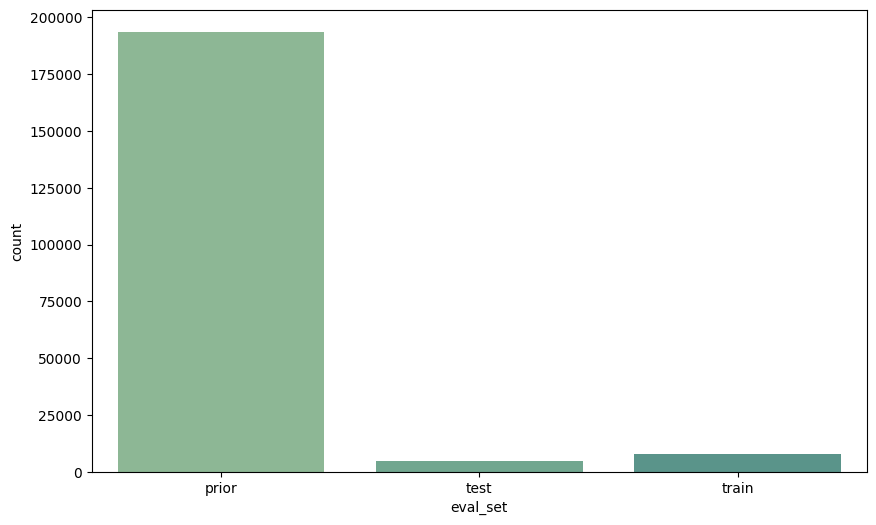

In [19]:
# Count of prior, train, test orders given in the data
sns.countplot(x='eval_set', data=orders, palette=colors)
plt.show()

In [20]:
# Merging the Prior and train order_products
order_products = pd.concat([order_products_train, order_products_prior])
order_products = order_products.merge(products, on='product_id', how='left').merge(orders, on='order_id', how='left').merge(departments, on='department_id').merge(aisles, on='aisle_id')

# Count of total orders
total_orders = order_products['order_id'].nunique()
print('Count of total orders: ', total_orders)

print('Merging products, order_products, and orders tables...')

order_products.head()

Count of total orders:  244709
Merging products, order_products, and orders tables...


,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,is_organic,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,department,aisle
0,1,49302.0,1.0,1.0,Bulgarian Yogurt,120.0,16.0,False,NaN,NaN,NaN,NaN,NaN,NaN,dairy eggs,yogurt
1,98,43654.0,3.0,1.0,Whole Milk Greek Blended Vanilla Bean Yogurt,120.0,16.0,False,NaN,NaN,NaN,NaN,NaN,NaN,dairy eggs,yogurt
2,170,8153.0,6.0,0.0,Plain Non-Fat Greek Yogurt,120.0,16.0,False,NaN,NaN,NaN,NaN,NaN,NaN,dairy eggs,yogurt
3,631,9203.0,13.0,1.0,Dairy Free Coconut Milk Raspberry Yogurt Alter...,120.0,16.0,False,NaN,NaN,NaN,NaN,NaN,NaN,dairy eggs,yogurt
4,631,15842.0,14.0,1.0,Dairy Free Coconut Milk Yogurt Alternative,120.0,16.0,False,NaN,NaN,NaN,NaN,NaN,NaN,dairy eggs,yogurt


### Ratio of reordered products
- 58.9697% of products in prior orders were re-ordered.
- 59.8594% of products in train orders were re-ordered.
- 11.868056% of orders having no reordered product.
- 21.493998% of orders having all product re-ordered.

<ipython-input-21-149dc626124e>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=reorder_ratio.index, y=reorder_ratio.values, palette=colors)
<ipython-input-21-149dc626124e>:3: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  ax = sns.barplot(x=reorder_ratio.index, y=reorder_ratio.values, palette=colors)
<ipython-input-21-149dc626124e>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['first-time ordered products', 'reordered'])


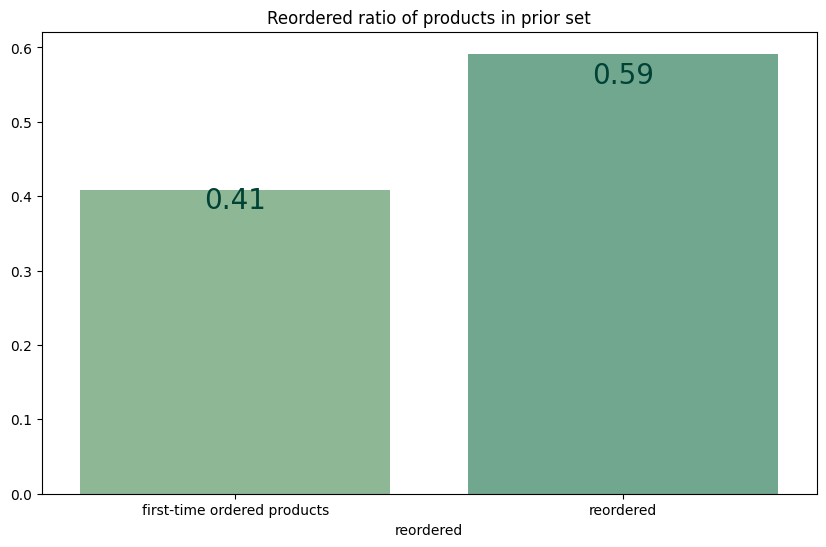

<ipython-input-21-149dc626124e>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=reorder_ratio.index, y=reorder_ratio.values, palette=colors)
<ipython-input-21-149dc626124e>:11: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  ax = sns.barplot(x=reorder_ratio.index, y=reorder_ratio.values, palette=colors)
<ipython-input-21-149dc626124e>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['first-time ordered products', 'reordered'])


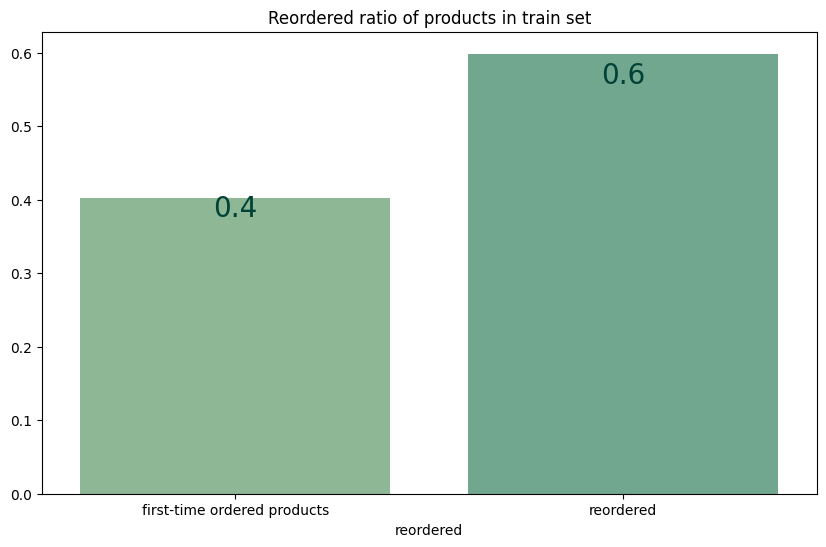

In [21]:
total_prod_count = order_products_prior.shape[0]
reorder_ratio = order_products_prior['reordered'].value_counts()/total_prod_count
ax = sns.barplot(x=reorder_ratio.index, y=reorder_ratio.values, palette=colors)
ax.set_xticklabels(['first-time ordered products', 'reordered'])
annotate_text(ax, append_to_text='')
plt.title('Reordered ratio of products in prior set')
plt.show()

total_prod_count = order_products_train.shape[0]
reorder_ratio = order_products_train['reordered'].value_counts()/total_prod_count
ax = sns.barplot(x=reorder_ratio.index, y=reorder_ratio.values, palette=colors)
ax.set_xticklabels(['first-time ordered products', 'reordered'])
annotate_text(ax, append_to_text='')
plt.title('Reordered ratio of products in train set')
plt.show()

<ipython-input-22-5ca07c716339>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=no_reordered_count.index, y=no_reordered_count.values, palette=colors)
<ipython-input-22-5ca07c716339>:13: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  ax = sns.barplot(x=no_reordered_count.index, y=no_reordered_count.values, palette=colors)
<ipython-input-22-5ca07c716339>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['atleast one reordered', 'no-reordered products'])


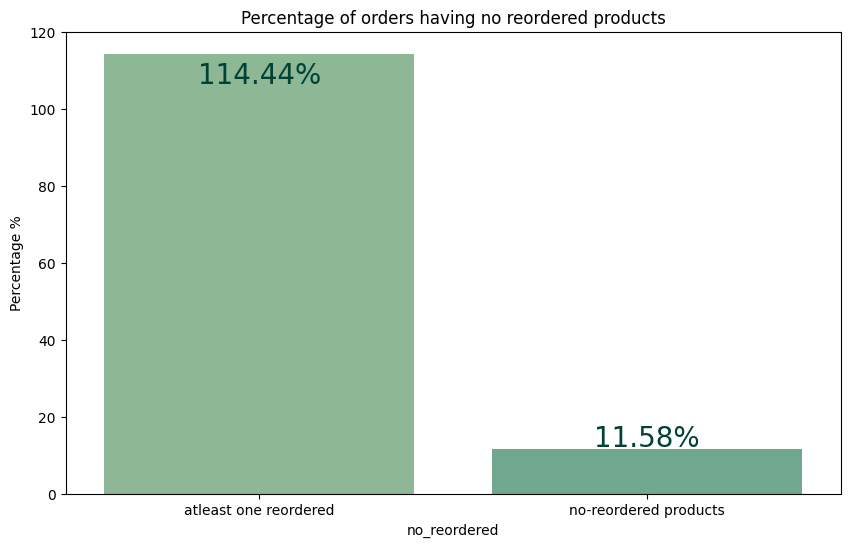

<ipython-input-22-5ca07c716339>:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=all_reordered_count.index, y=all_reordered_count.values, palette=colors)
<ipython-input-22-5ca07c716339>:23: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  ax = sns.barplot(x=all_reordered_count.index, y=all_reordered_count.values, palette=colors)
<ipython-input-22-5ca07c716339>:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['not purely all products are reordered', 'all products are reordered'])


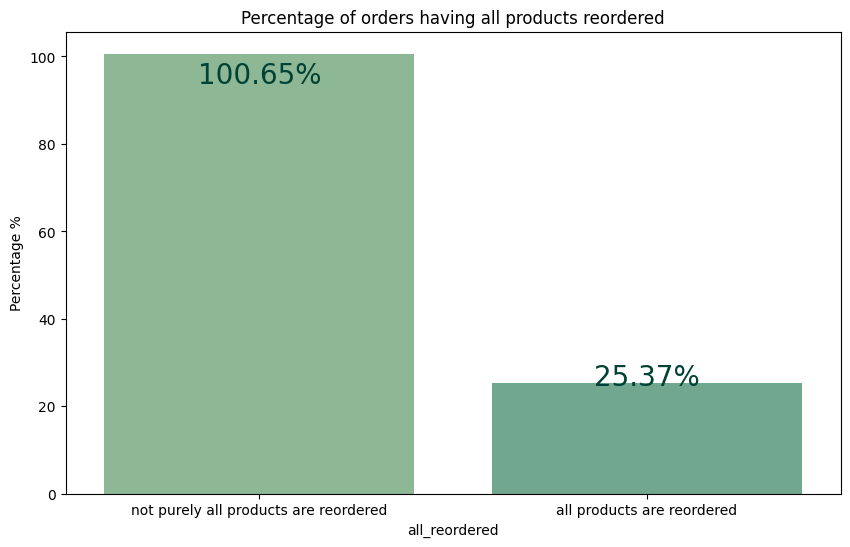

,order_id,reordered_ratio,order_number,no_reordered,all_reordered
0,1,0.500000,NaN,False,False
1,2,0.666667,NaN,False,False
2,3,1.000000,NaN,False,True
3,4,0.923077,NaN,False,False
4,5,0.807692,NaN,False,False


In [22]:
groupeddf = order_products.groupby(['order_id']).agg({'reordered':'mean', 'order_number':'first'}).reset_index().rename(columns={'reordered':'reordered_ratio'})
groupeddf['no_reordered'] = groupeddf['reordered_ratio'] == 0
groupeddf['all_reordered'] = groupeddf['reordered_ratio'] == 1.0

# Count of non-first orders
non_first_orders_Mask = orders.order_number != 1
non_first_orders_count = np.sum(non_first_orders_Mask)

# Ratio of non-first orders containing no previously ordered products vs containing at least one previously ordered products
groupeddf = groupeddf[groupeddf.order_number != 1]
groupeddf['no_reordered'] = groupeddf['reordered_ratio'] == 0
no_reordered_count = groupeddf['no_reordered'].value_counts()/non_first_orders_count * 100
ax = sns.barplot(x=no_reordered_count.index, y=no_reordered_count.values, palette=colors)
annotate_text(ax)
ax.set_xticklabels(['atleast one reordered', 'no-reordered products'])
plt.title('Percentage of orders having no reordered products')
plt.ylabel('Percentage %')
plt.show()

# Ratio of non-first orders where their products were all previously purchased
groupeddf['all_reordered'] = groupeddf['reordered_ratio'] == 1.0
all_reordered_count = groupeddf['all_reordered'].value_counts()/non_first_orders_count * 100
ax = sns.barplot(x=all_reordered_count.index, y=all_reordered_count.values, palette=colors)
annotate_text(ax)
ax.set_xticklabels(['not purely all products are reordered', 'all products are reordered'])
plt.title('Percentage of orders having all products reordered')
plt.ylabel('Percentage %')
plt.show()

groupeddf.head()

- Most baskets contain from 5-8 products.
- Products placed first in cart are the products mostly reordered.

<ipython-input-23-09fe5811bfc1>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='count_of_products', data=count_of_products, palette=colors)
<ipython-input-23-09fe5811bfc1>:5: UserWarning: 
The palette list has fewer values (5) than needed (82) and will cycle, which may produce an uninterpretable plot.
  sns.countplot(x='count_of_products', data=count_of_products, palette=colors)
<ipython-input-23-09fe5811bfc1>:9: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.category.StrCategoryLocator'>
  plt.locator_params(nbins=20)


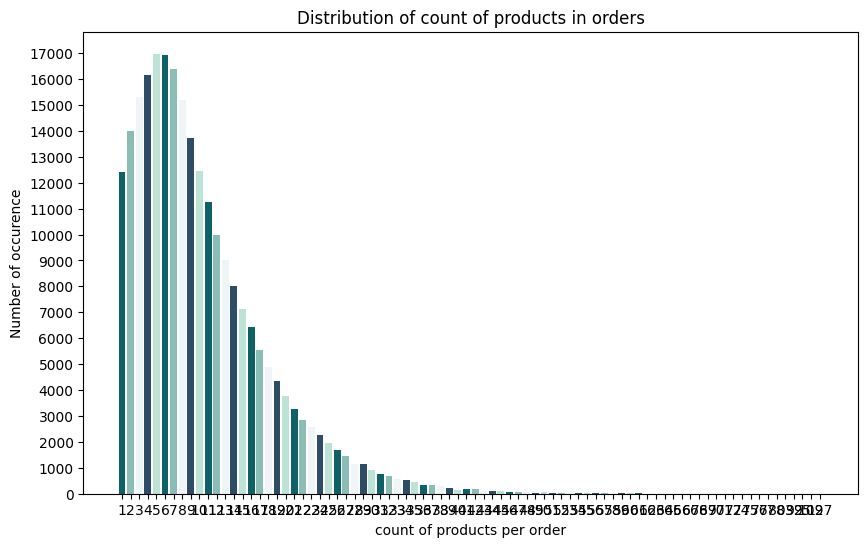

In [23]:
# Ploting a histogram for the # of products in an order
count_of_products = order_products.groupby(['order_id'], as_index=False)['product_id'].count()
count_of_products['count_of_products'] = count_of_products['product_id']
colors = sns.color_palette(['#006D77', '#83C5BE', '#EDF6F9', '#234E70', '#B5EAD7'])
sns.countplot(x='count_of_products', data=count_of_products, palette=colors)
plt.xlabel('count of products per order')
plt.ylabel('Number of occurence')
plt.title('Distribution of count of products in orders')
plt.locator_params(nbins=20)
plt.show()

del count_of_products

<ipython-input-33-08e81e754229>:6: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x=groupeddf['add_to_cart_order'], y=groupeddf['reordered_ratio'], palette=colors)


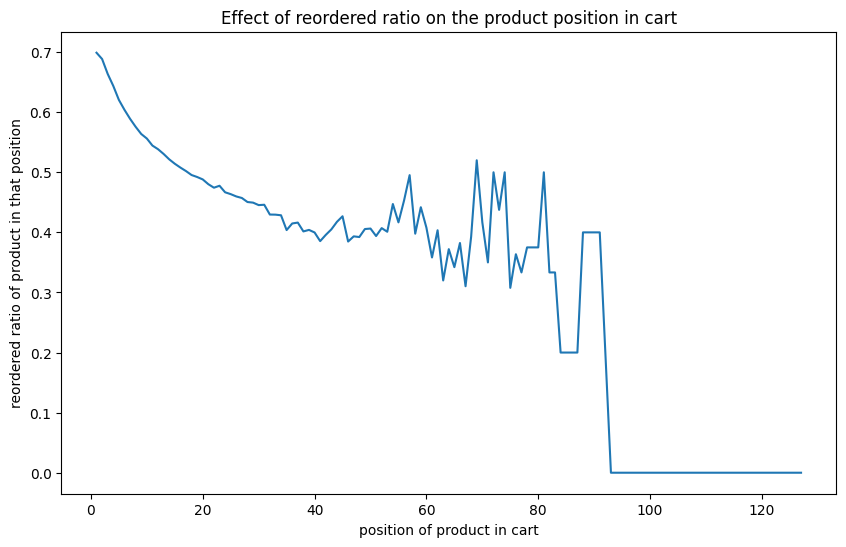

In [33]:
# Relation between the order number and the reorder ratio of that order

# Relation between the add to cart postiion and the reorder ratio of that product
order_products['add_to_cart_order'] = order_products['add_to_cart_order'].astype('int64')
groupeddf = order_products.groupby(['add_to_cart_order']).agg({'reordered':'mean'}).rename(columns={'reordered':'reordered_ratio'}).reset_index()
sns.lineplot(x=groupeddf['add_to_cart_order'], y=groupeddf['reordered_ratio'], palette=colors)
plt.title('Effect of reordered ratio on the product position in cart')
plt.xlabel('position of product in cart')
plt.ylabel('reordered ratio of product in that position')
plt.show()

### Analyzing the count of reordered products in a basket
- Most baskets have from 0-5 reordered product
- Probability of a basket having 0 reordered products: 11.868056
- Probability of a basket having 1 reordered products: 10.262626
- Probability of a basket having 2 reordered products: 10.326791
- Probability of a basket having 3 reordered products: 9.735981
- Probability of a basket having 4 reordered products: 8.777965

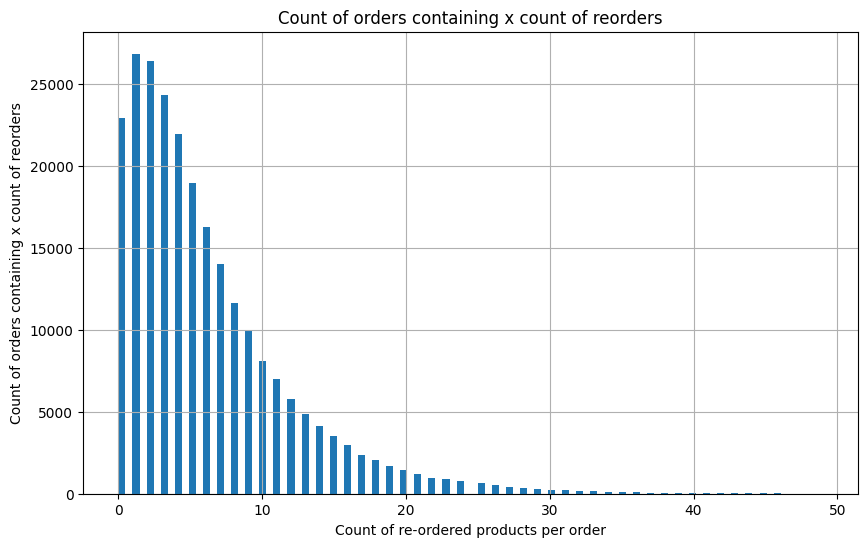

<ipython-input-34-a3a631d6cd05>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=reordered_products_count_histogram['count_of_reordered_products'], y=reordered_products_count_histogram['percentage_of_this_reordered_count'].values, palette=colors)
<ipython-input-34-a3a631d6cd05>:22: UserWarning: 
The palette list has fewer values (5) than needed (21) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x=reordered_products_count_histogram['count_of_reordered_products'], y=reordered_products_count_histogram['percentage_of_this_reordered_count'].values, palette=colors)


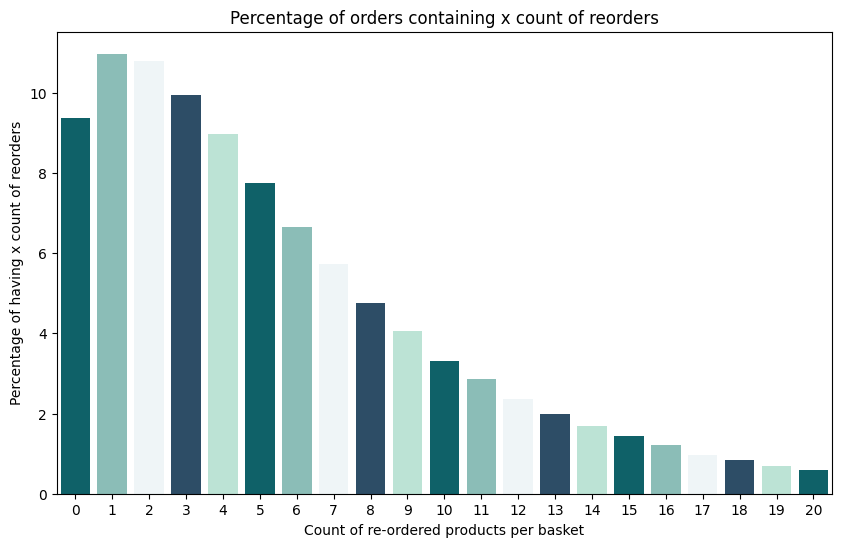

In [34]:
# Ploting a histogram for the # of reordered products in an order
count_of_reordered_products = order_products.groupby(['order_id'], as_index=False)['reordered'].sum()
count_of_reordered_products['count_of_reordered_products'] = count_of_reordered_products['reordered']
less_than_50_reordered_products = count_of_reordered_products[count_of_reordered_products['count_of_reordered_products']<50]
less_than_50_reordered_products['count_of_reordered_products'].hist(bins=100)
plt.ylabel('Count of orders containing x count of reorders')
plt.xlabel('Count of re-ordered products per order')
plt.title('Count of orders containing x count of reorders')

plt.show()

# Percentage of orders having x count_of_reordered_products
count_of_reordered_products['count_of_reordered_products'] = count_of_reordered_products['count_of_reordered_products'].astype(int)
reordered_products_count_histogram = count_of_reordered_products.groupby(['count_of_reordered_products'], as_index=False).count()
reordered_products_count_histogram['count_of_orders'] = reordered_products_count_histogram['reordered']
reordered_products_count_histogram['percentage_of_this_reordered_count'] = (reordered_products_count_histogram['count_of_orders']/total_orders) * 100
reordered_products_count_histogram = reordered_products_count_histogram[['count_of_reordered_products','count_of_orders','percentage_of_this_reordered_count']]
# Filter reorders counts occuring by prob less than 0.5%
mask = reordered_products_count_histogram['percentage_of_this_reordered_count'] > 0.5
reordered_products_count_histogram = reordered_products_count_histogram[mask].sort_values(by=['percentage_of_this_reordered_count'], ascending=False)

sns.barplot(x=reordered_products_count_histogram['count_of_reordered_products'], y=reordered_products_count_histogram['percentage_of_this_reordered_count'].values, palette=colors)
plt.ylabel('Percentage of having x count of reorders')
plt.xlabel('Count of re-ordered products per basket')
plt.title('Percentage of orders containing x count of reorders')
plt.show()

reordered_products_count_histogram.head()

del less_than_50_reordered_products, count_of_reordered_products, reordered_products_count_histogram, mask

### Analyzing Behaviour of users
### Users always order previously ordered products:
Count of users: 685

## Time effects on purchasing behaviours

### How Time affects the purchasing behaviour of customers?
- Most orders are ordered on Day 0 and Day 1.
- Orders are mostly ordered during day, from 9:00 AM to 4:00 PM.
- Peak orders happens at Saturday afternoon (1:00PM), and Sunday morning (10:00AM)
- By more than 65%, People usually buy previously ordered products from 6:00AM to 8:00AM
- Most users make orders after a week from their last order. or from a month of their last order.
- After a week from the last order, the probability of reordering within the same month is small.
    - Send reminders of the most likely ordered products within a week, to catch the high prob of a customer to make their next order.
- The Next order has higher probability to be during 10 days from the current order.

<ipython-input-39-f64df5307d21>:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=orders, x='order_dow', palette=colors, bins=7)


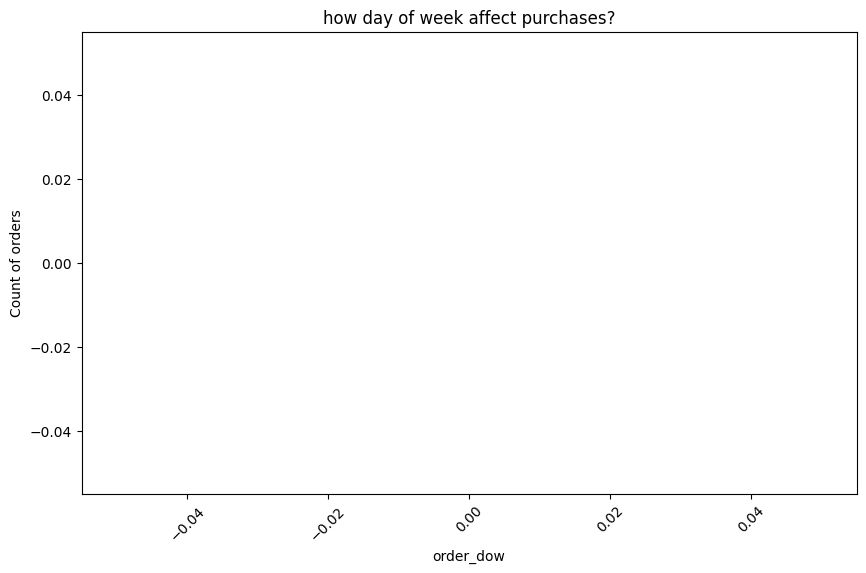

<ipython-input-39-f64df5307d21>:10: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=orders, x='order_hour_of_day', palette=colors, bins=24)


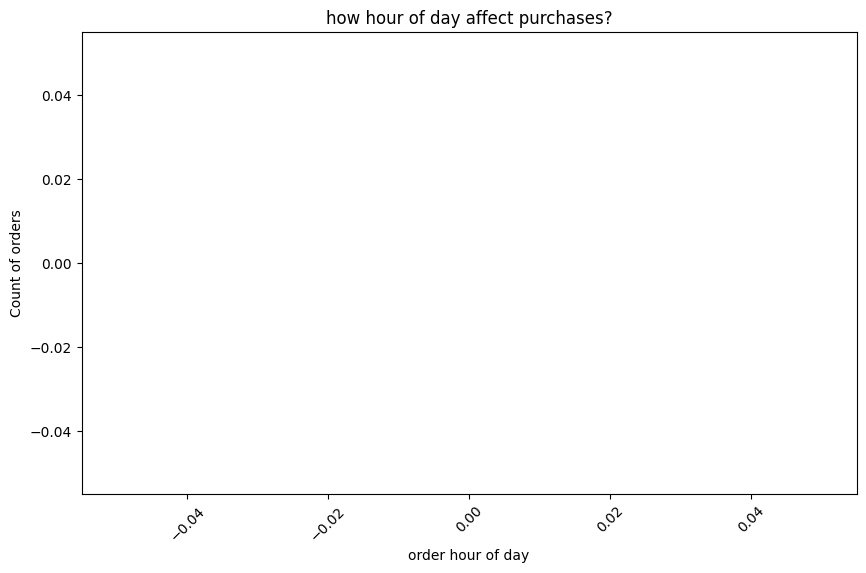

<ipython-input-39-f64df5307d21>:18: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=orders, x='days_since_prior_order', palette=colors, bins=30)


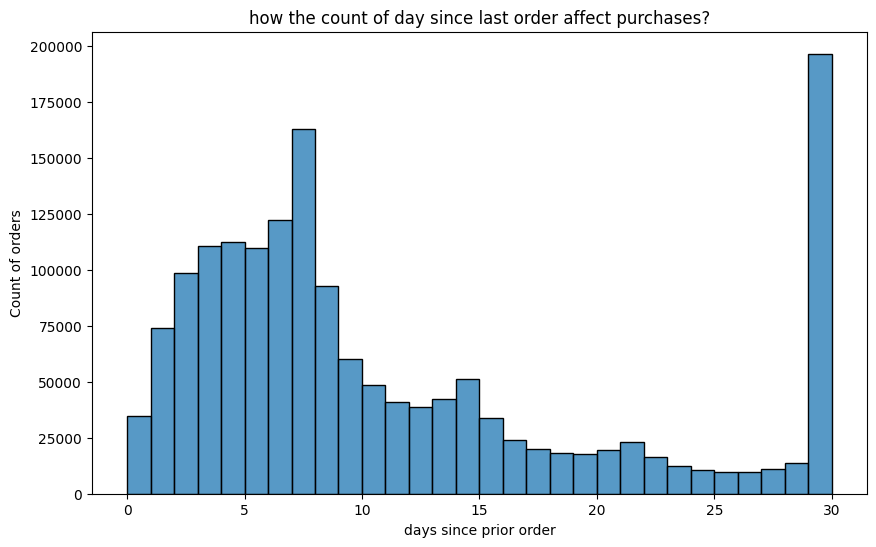

In [ ]:
# Histogram for order day of week
sns.histplot(data=orders, x='order_dow', palette=colors, bins=7)
plt.xlabel('order_dow')
plt.ylabel('Count of orders')
plt.title('how day of week affect purchases?')
plt.xticks(rotation= 45)
plt.show()

# Histogram for order hour of day
sns.histplot(data=orders, x='order_hour_of_day', palette=colors, bins=24)
plt.xlabel('order hour of day')
plt.xticks(rotation= 45)
plt.ylabel('Count of orders')
plt.title('how hour of day affect purchases?')
plt.show()

# Histogram for days passed before last order
sns.histplot(data=orders, x='days_since_prior_order', palette=colors, bins=30)
plt.xlabel('days since prior order')
plt.ylabel('Count of orders')
plt.title('how the count of day since last order affect purchases?')
plt.show()

<ipython-input-36-88f8f24ff63e>:3: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  heatmap_data = groupeddf.pivot('order_dow', 'order_hour_of_day', 'orders_count')


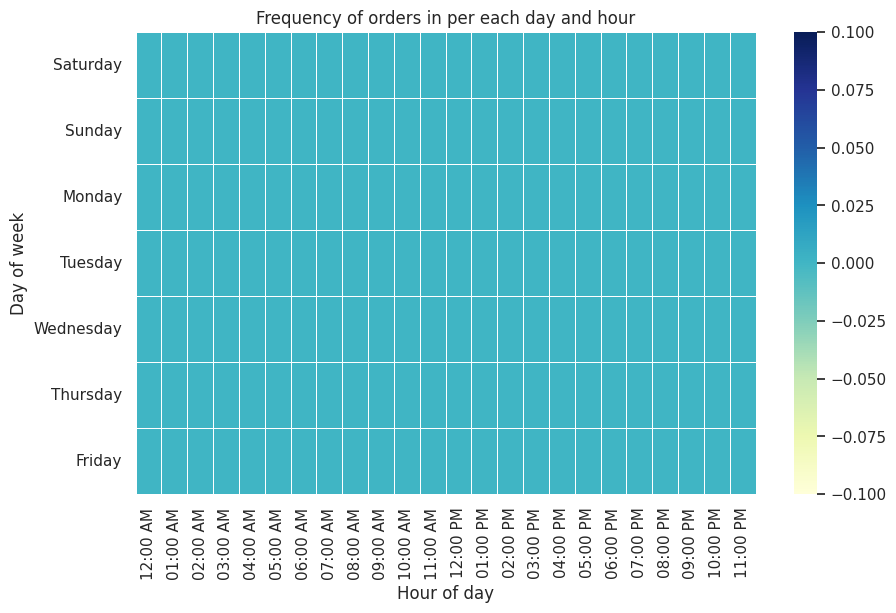

In [ ]:
# Heatmap of the count of orders in each day with each hour
groupeddf = orders.groupby(['order_dow', 'order_hour_of_day'])['order_id'].agg('count').reset_index().rename(columns={'order_id':'orders_count'})
heatmap_data = groupeddf.pivot('order_dow', 'order_hour_of_day', 'orders_count')

ax = sns.heatmap(data=heatmap_data, cmap="YlGnBu", linewidths=.5)
plt.title('Frequency of orders in per each day and hour')
plt.ylabel('Day of week')
plt.xlabel('Hour of day')
plt.show()

<ipython-input-37-03dd8e20c959>:4: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  heatmap_data = groupeddf.pivot('order_dow', 'order_hour_of_day', 'reordered_ratio')
/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


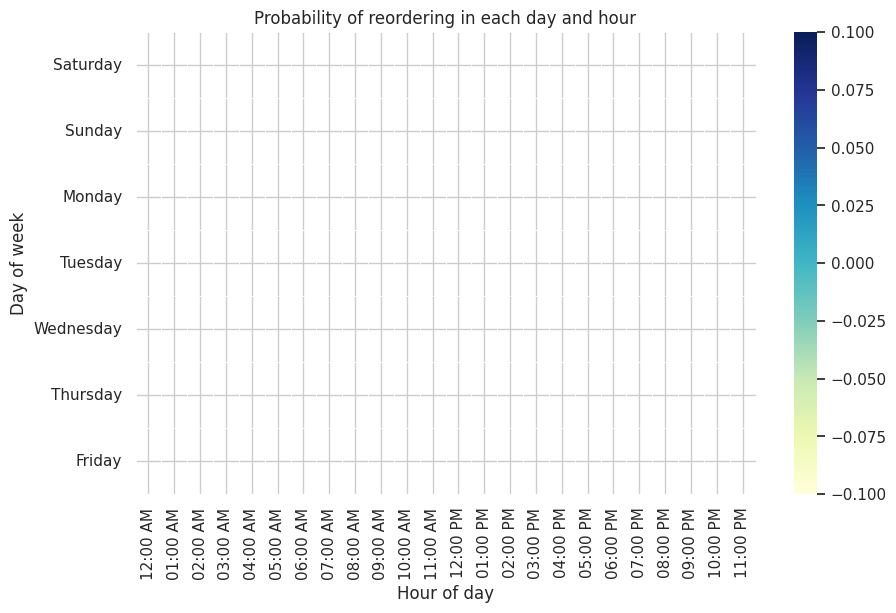

In [ ]:
# Heatmap on the propability of non-new users to reorder for each day each hour
non_first_orders = order_products['order_number'] != 1
groupeddf = order_products[non_first_orders].groupby(['order_dow', 'order_hour_of_day']).agg({'reordered':'mean'}).reset_index().rename(columns={'reordered':'reordered_ratio'})
heatmap_data = groupeddf.pivot('order_dow', 'order_hour_of_day', 'reordered_ratio')

ax = sns.heatmap(data=heatmap_data, cmap="YlGnBu", linewidths=.5)
plt.title('Probability of reordering in each day and hour')
plt.ylabel('Day of week')
plt.xlabel('Hour of day')
plt.show()

### Association between days since last order and the ratio of reorders
- 74 % of products bought at the same day of prev order, are reorders
- 69% of products bought after 1 week of prev order, are reorders
- Conculsion:
    - if future order will be at the same day of prev order, percentage of reorders in the future product is high.
    - if future order will be after a week from the prev order, percentage of reorders in the future product is high.


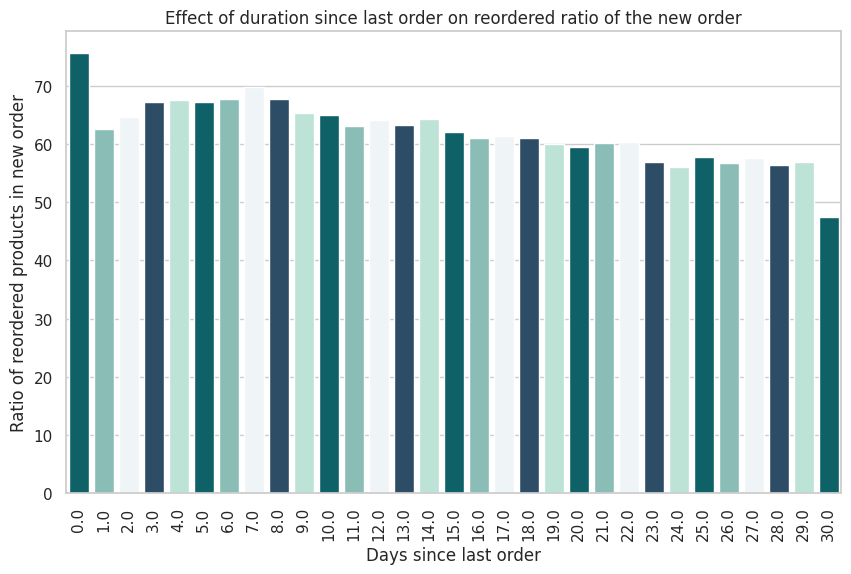

In [ ]:
groupeddf = order_products.groupby(['days_since_prior_order']).agg({'reordered': 'mean'}).rename(columns={'reordered':'reordered_ratio'}).reset_index()
sns.barplot(x=groupeddf['days_since_prior_order'], y=groupeddf['reordered_ratio']*100, palette=colors)
plt.ylabel('Ratio of reordered products in new order')
plt.xlabel('Days since last order')
plt.xticks(rotation=90)
plt.title('Effect of duration since last order on reordered ratio of the new order')
plt.show()

## Analyzing products

### How often a product is purchased?
- 5 Most Ordered Products
    - Banana
    - Bag of Organic Bananas
    - Organic Strawberries
    - Organic Baby Spinach
    - Organic Hass Avocado
- 14% of all orders contains bananas.
- Organic products are frequently ordered.

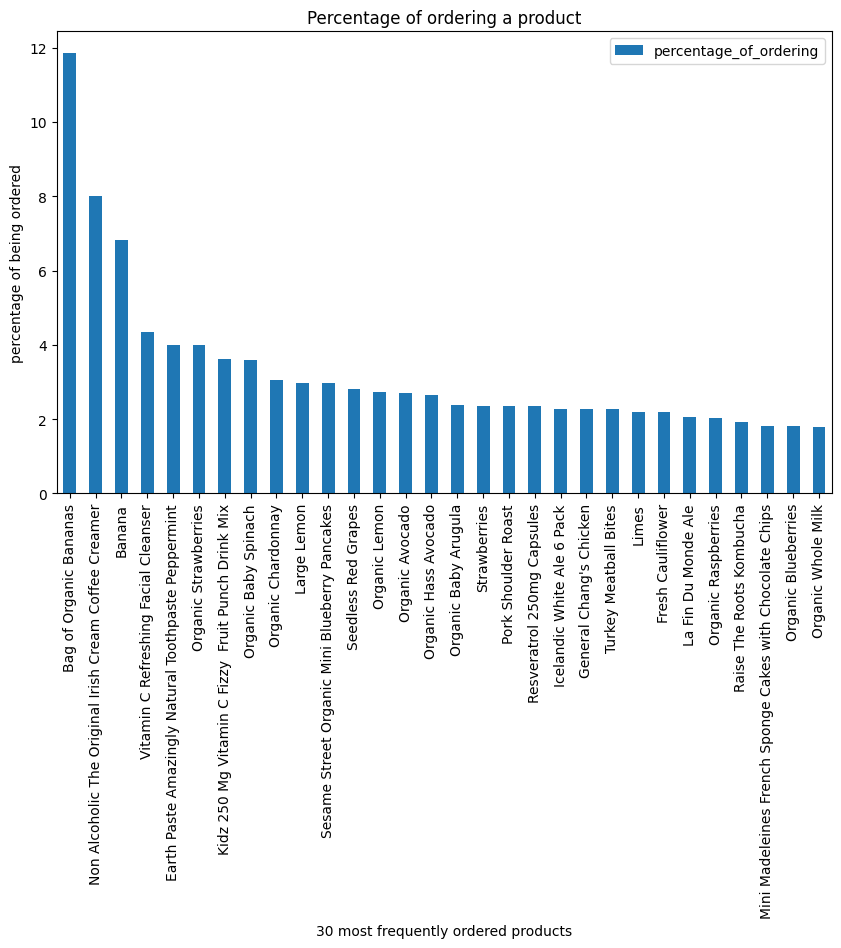

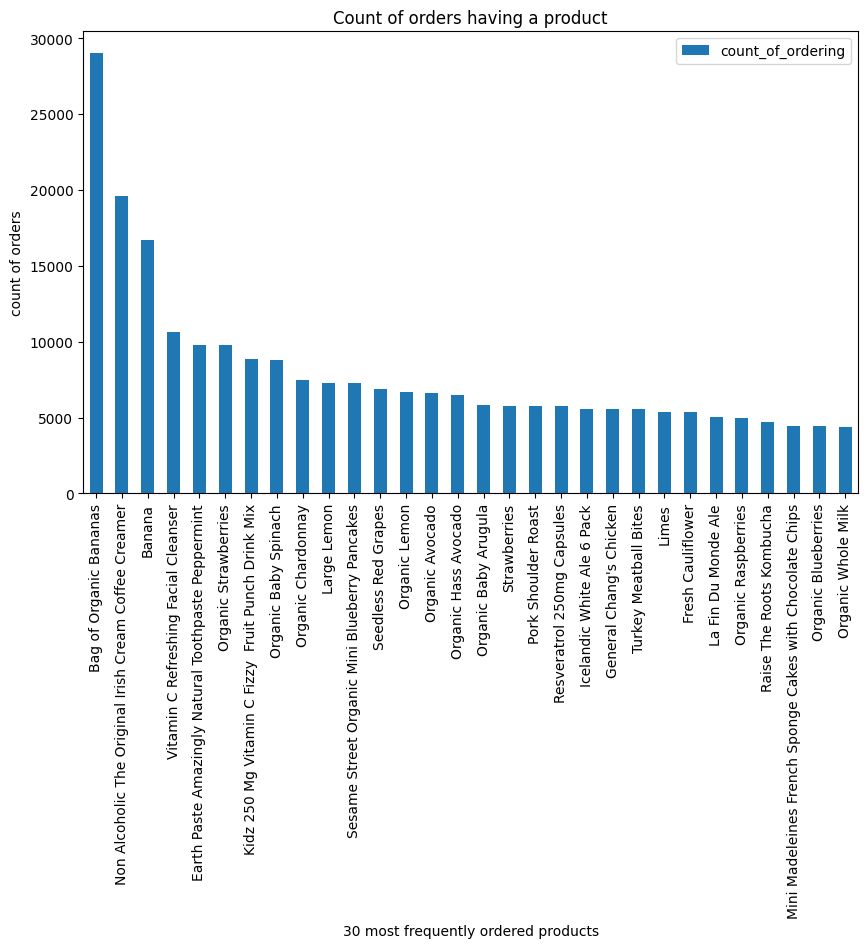

In [38]:
# Sorting products descendingly by their frequency of being ordered
products_frequency_desc = order_products.groupby('product_name')['order_id'].aggregate('count').reset_index()
products_frequency_desc['count_of_ordering'] =  products_frequency_desc['order_id']
products_frequency_desc = products_frequency_desc.sort_values(by=['count_of_ordering'], ascending=False)

# Ploting the Percentage of being ordered for the 30 most frequently ordered products.
products_frequency_desc['percentage_of_ordering'] = (products_frequency_desc['count_of_ordering']/total_orders) * 100
products_frequency_desc.iloc[:30].plot.bar(x='product_name', y='percentage_of_ordering')
plt.xlabel('30 most frequently ordered products')
plt.ylabel('percentage of being ordered')
plt.xticks(rotation=90)
plt.title('Percentage of ordering a product')
plt.show()

products_frequency_desc.iloc[:30].plot.bar(x='product_name', y='count_of_ordering')
plt.xlabel('30 most frequently ordered products')
plt.ylabel('count of orders')
plt.xticks(rotation=90)
plt.title('Count of orders having a product')
plt.show()

del products_frequency_desc

### How often a product is the first item purchased?
- 5 Most Add to Cart First Products
    - Banana
    - Bag of Organic Bananas
    - Organic Whole Milk
    - Organic Strawberries
    - Organic Hass Avocado
- 3.4% of the orders, Banana is being the first product added to cart.
- Products contianing milk have very high probability to be reordered.
- Organic products have very high probability to be reordered.

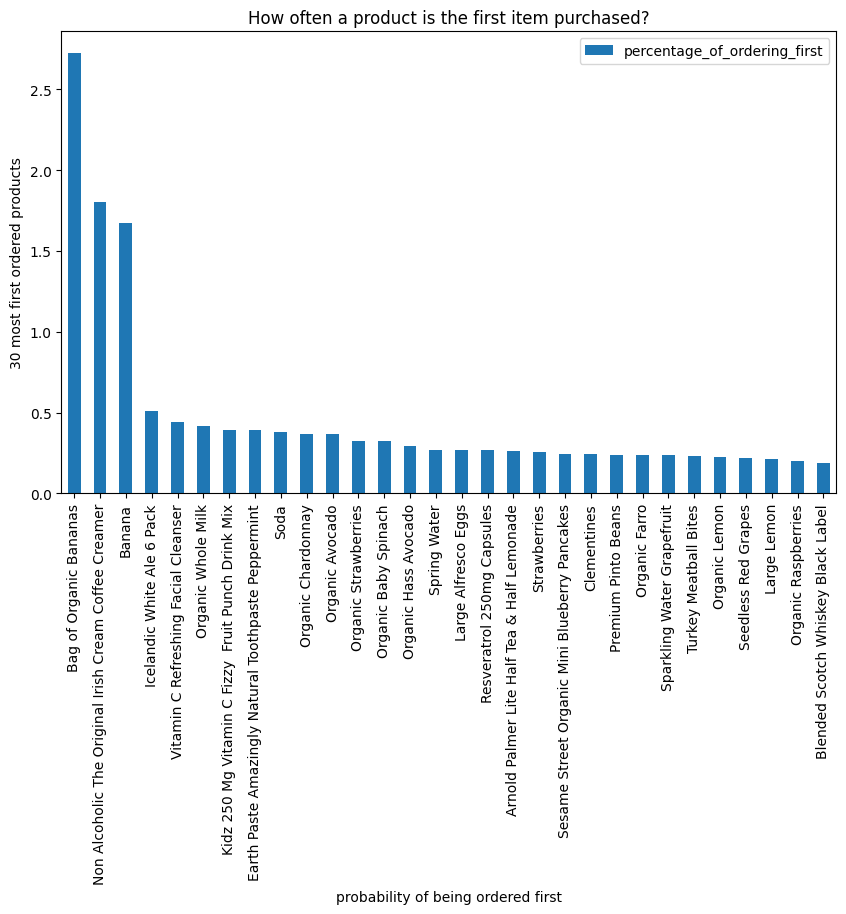

In [39]:
# Sorting Products by the count of times they appeared first in cart.
first_order_product = order_products[order_products['add_to_cart_order'] == 1]
first_product_freq_desc = first_order_product.groupby(['product_name'], as_index = False)['order_id'].count().sort_values(by=['order_id'], ascending=False)
first_product_freq_desc['count_of_ordering_first'] = first_product_freq_desc['order_id']

# Ploting the Percentage of being ordered first for the 30 most first ordered products.
first_product_freq_desc['percentage_of_ordering_first'] = (first_product_freq_desc['count_of_ordering_first']/total_orders) * 100
first_product_freq_desc.iloc[:30].plot.bar(x='product_name', y='percentage_of_ordering_first')
plt.ylabel('30 most first ordered products')
plt.xlabel('probability of being ordered first')
plt.xticks(rotation=90)
plt.title('How often a product is the first item purchased?')
plt.show()

del first_order_product, first_product_freq_desc

### If the product is in the basket, what is the probability it was the first item added?
#### Can't find a pattern or product if exists in basket, it will strongly be added the first item.

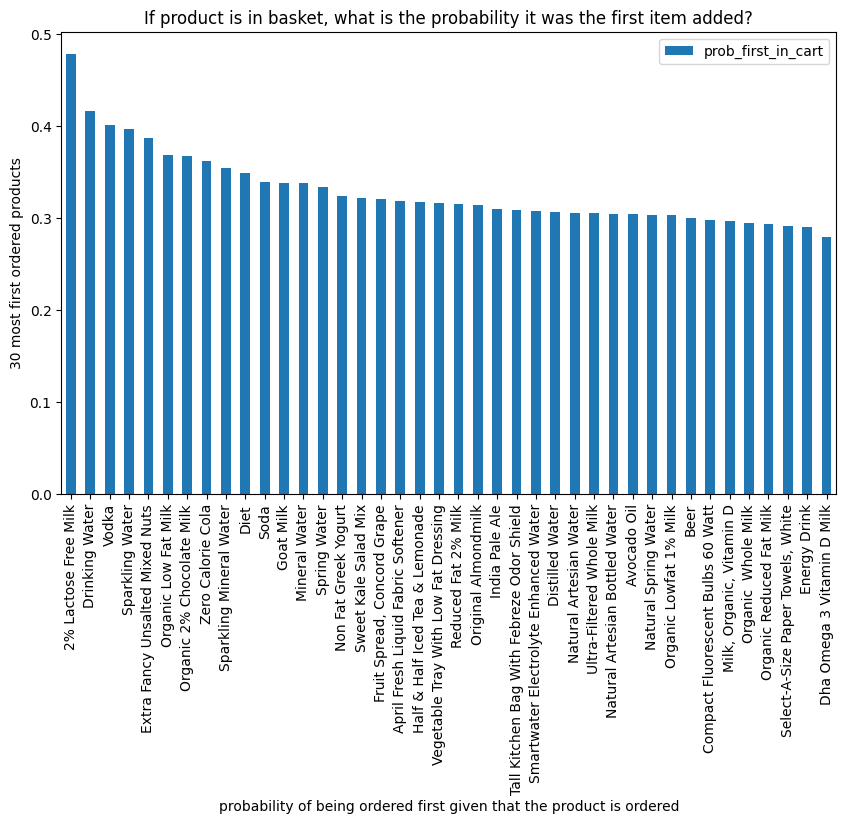

In [40]:
# Sorting Products by the count of times they appeared first in cart.
order_products['is_first_in_cart'] = order_products['add_to_cart_order'] == 1
groupeddf = order_products.groupby(['product_name'], as_index = False).agg({'is_first_in_cart': 'mean', 'order_id': 'count'}).rename(columns={'is_first_in_cart':'prob_first_in_cart', 'order_id':'orders_count'})
confident_products_mask = groupeddf['orders_count'] > 100
groupeddf = groupeddf[confident_products_mask].sort_values(by='prob_first_in_cart', ascending=False)

# Ploting the Percentage of being ordered first for the 30 most first ordered products.
groupeddf.iloc[:40].plot.bar(x='product_name', y='prob_first_in_cart')
plt.ylabel('30 most first ordered products')
plt.xlabel('probability of being ordered first given that the product is ordered')
plt.title('If product is in basket, what is the probability it was the first item added?')
plt.xticks(rotation=90)
plt.show()

del confident_products_mask

### Probability of reordering a product

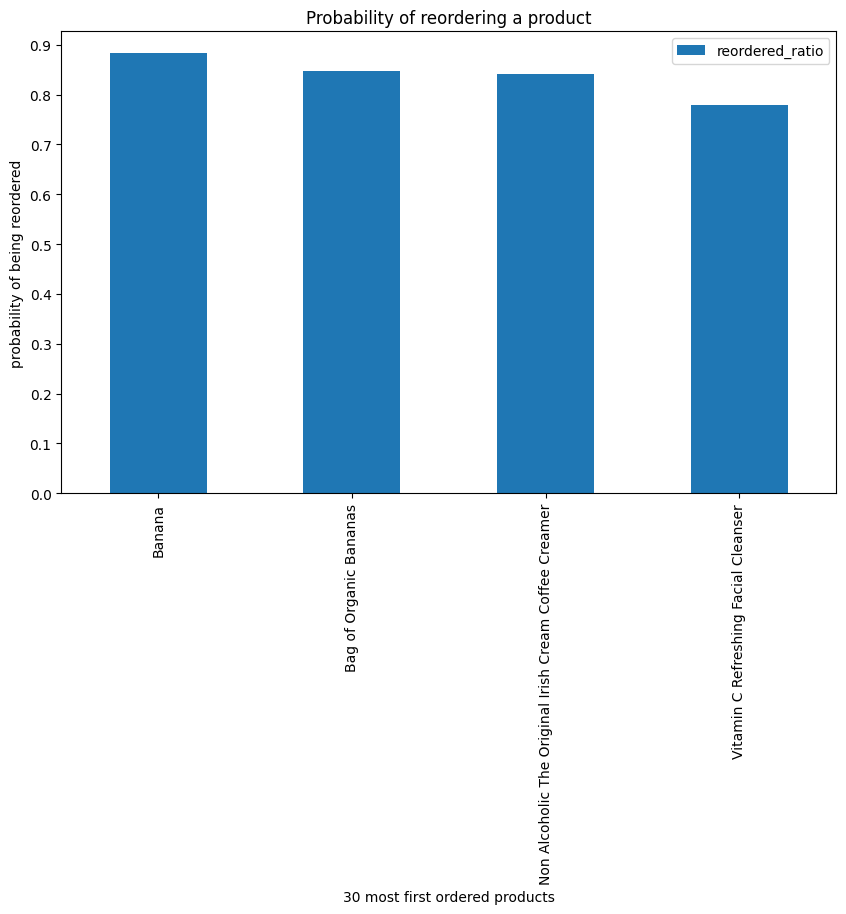

In [41]:
# For each product what is its probability to be reordered.
# We don't consider the first order of the user because 100% it won't contain any prev. ordered products.
non_first_orders_Mask = order_products['order_number'] != 1
groupeddf = order_products[non_first_orders_Mask].groupby('product_name').agg({'order_id':'count','reordered':'mean'}).reset_index().rename(columns={'reordered':'reordered_ratio', 'order_id':'orders_count'})

# Filter products under 10000 order count
groupeddf = groupeddf[groupeddf['orders_count']>10000]
# Sort by the products having highest prob to be reordered
groupeddf = groupeddf.sort_values(by=['reordered_ratio'], ascending=False)

ax = groupeddf.iloc[:30].plot.bar(x='product_name', y='reordered_ratio')
plt.xlabel('30 most first ordered products')
plt.ylabel('probability of being reordered')
plt.xticks(rotation=90)
plt.title('Probability of reordering a product')
ax.set_yticks(np.arange(0.0, 1.0, 0.1))
plt.show()

del non_first_orders_Mask

### Analyzing Organic Prodcuts

- 10% of instacart's products are organic products
- 31.5% of bought products are organic products
- 67% probability of reordering an organic products.
- 61% probability of reordering an non-organic products.
- No significance pattern of when organic products are bought most, than when products in general are bought most.

<ipython-input-42-438474355bbd>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x= organic_ratio.index, y=organic_ratio.values, palette=colors)
<ipython-input-42-438474355bbd>:4: UserWarning: The palette list has more values (5) than needed (2), which may not be intended.
  ax = sns.barplot(x= organic_ratio.index, y=organic_ratio.values, palette=colors)


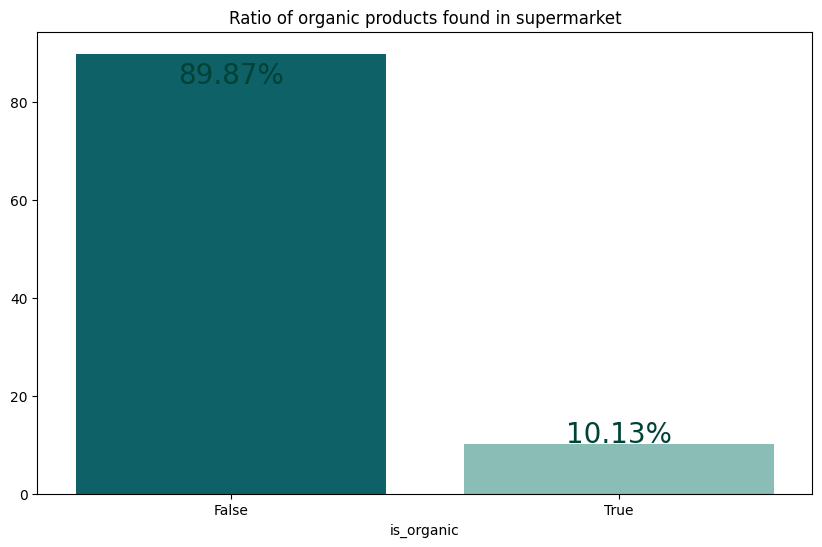

In [42]:
# Ratio of organic products found in supermarket
total_products_count = products.shape[0]
organic_ratio = products['is_organic'].value_counts()/total_products_count*100
ax = sns.barplot(x= organic_ratio.index, y=organic_ratio.values, palette=colors)
annotate_text(ax)
plt.title('Ratio of organic products found in supermarket')
plt.show()

<ipython-input-43-2316ceaba68e>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x= organic_freq.index, y=organic_freq.values, palette=colors)
<ipython-input-43-2316ceaba68e>:4: UserWarning: The palette list has more values (5) than needed (2), which may not be intended.
  ax = sns.barplot(x= organic_freq.index, y=organic_freq.values, palette=colors)
<ipython-input-43-2316ceaba68e>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['non-organic', 'organic'])


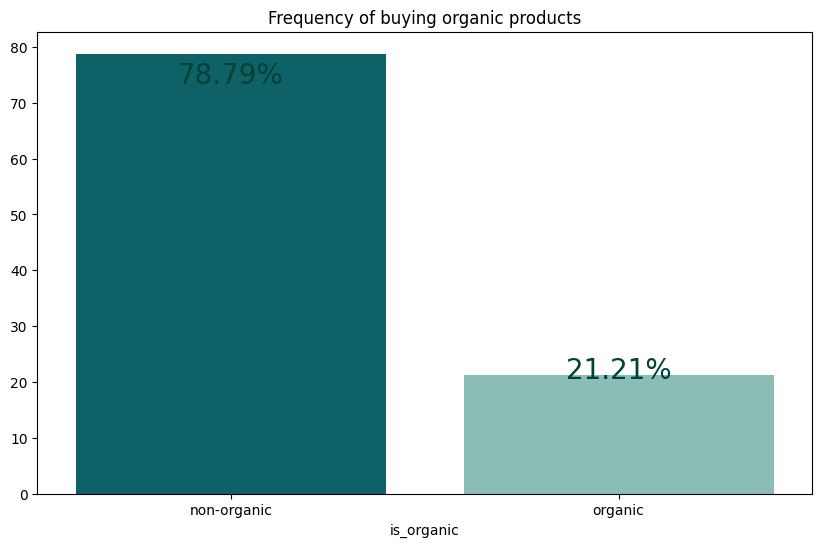

In [43]:
# Frequency of buying organic products
total_order_products_count = order_products.shape[0]
organic_freq = order_products['is_organic'].value_counts()/total_order_products_count*100
ax = sns.barplot(x= organic_freq.index, y=organic_freq.values, palette=colors)
ax.set_xticklabels(['non-organic', 'organic'])
annotate_text(ax)
plt.title('Frequency of buying organic products')
plt.show()

<ipython-input-44-eb9ab5a2a804>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='is_organic', y='reordered_ratio', data=groupeddf, palette=colors)
<ipython-input-44-eb9ab5a2a804>:4: UserWarning: The palette list has more values (5) than needed (2), which may not be intended.
  ax = sns.barplot(x='is_organic', y='reordered_ratio', data=groupeddf, palette=colors)
<ipython-input-44-eb9ab5a2a804>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['non-organic', 'organic'])


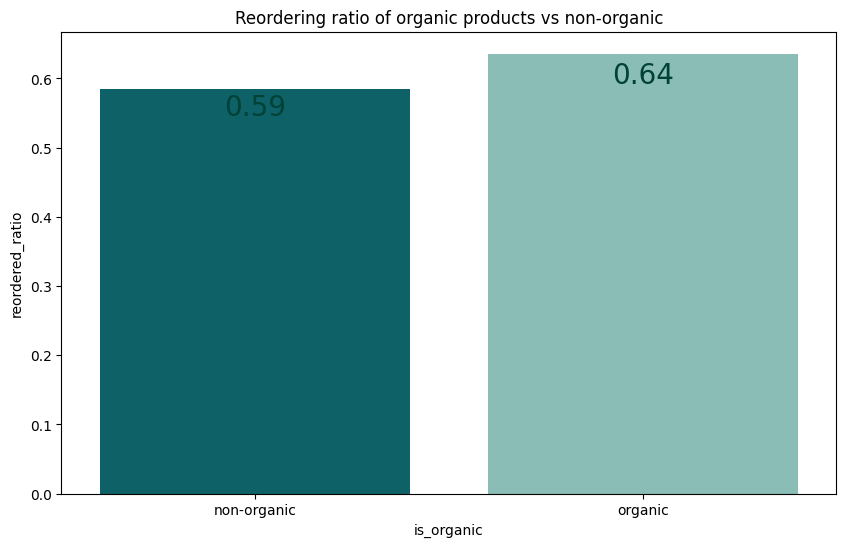

In [44]:
# Reordering ratio of organic products vs non-organic
non_first_orders_mask = order_products['order_number'] != 1
groupeddf = order_products[non_first_orders_mask].groupby(['is_organic']).agg({'reordered':'mean'}).rename(columns={'reordered':'reordered_ratio'}).reset_index()
ax = sns.barplot(x='is_organic', y='reordered_ratio', data=groupeddf, palette=colors)
annotate_text(ax, append_to_text='')
ax.set_xticklabels(['non-organic', 'organic'])
plt.title('Reordering ratio of organic products vs non-organic')
plt.show()

Comment:
- Heatmap of buying an organic product is very similar to heatmap of buying any products.
- This indicates that buying an organic product is not tied to specific time, but the time orders are mostly purchased at.

### Analyzing Department and Aisles
- Departments cotaining large count of products
    - Personal care
    - Pantry
    - Snacks
- 5 Most departments ordered from
    - 29% of ordered products from department: produce
    - dairy eggs
    - snacks
    - beverages
    - frozen
- 5 Most aisles ordered from
    - 14% of ordered products from aisle: fresh fruit
    - fresh vegetables
    - packaged vegetables fruits
    - yogurt
    - packaged cheese
- 3 Most reordered from departments
- dairy eggs: by 71% products from this department will be reordered
- beverages: by 69.5% products from this department will be reordered
- produce: : by 69.13% products from this department will be reordered

## Purchasing behaviour on Departments and Aisles
#### Count of products in each department

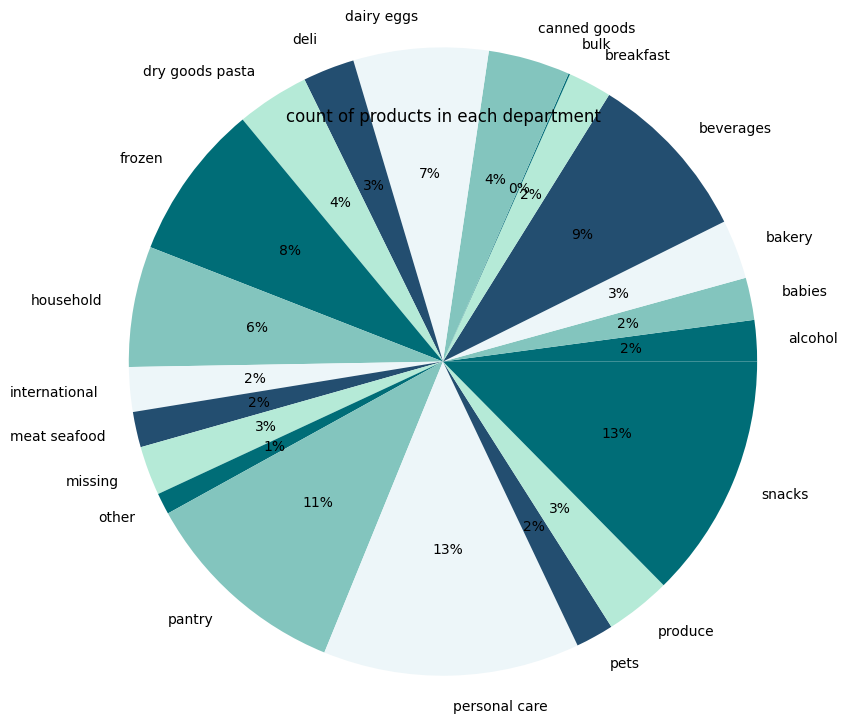

In [56]:
# count of products in each department

# merge products with departments
prod_dept = products.merge(departments, on='department_id', how='left')
data = prod_dept.groupby(['department']).agg({'product_id':'count'}).reset_index().rename(columns={'product_id':'products_count'})
plt.pie(data['products_count'], labels = data['department'], colors = colors, autopct='%.0f%%', radius=1.7)
plt.title('count of products in each department')
plt.show()

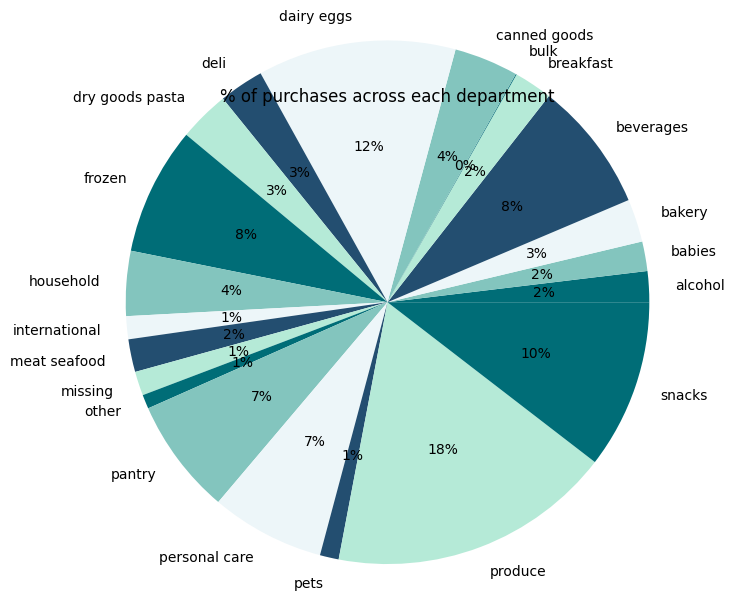

In [60]:
# From All ordered products, the count of contribution of each department
# Group by the count of ordering from a department
total_ordered_products = order_products.shape[0]
groupeddf = order_products.groupby(['department'], as_index=False).count().rename(columns={'department_id':'count_of_ordered_prods'})

fig = plt.figure(figsize = (20, 5))
plt.pie(groupeddf['count_of_ordered_prods'], labels = groupeddf['department'], colors = colors, autopct='%.0f%%', radius=1.7)
plt.title('% of purchases across each department')
plt.show()

<Figure size 2000x500 with 0 Axes>

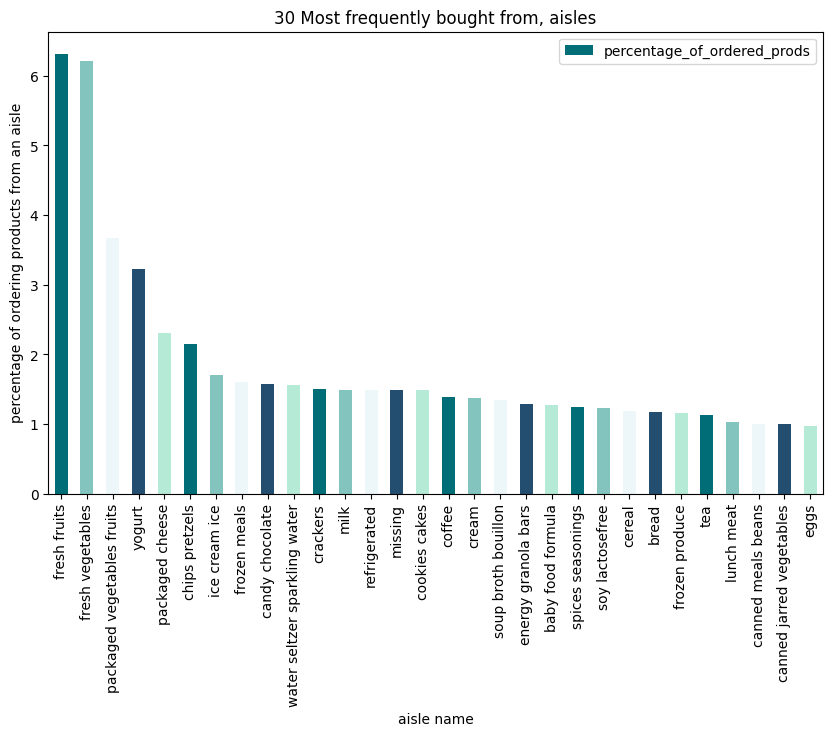

In [61]:
# From All ordered products, the count of contribution of each aisle
# Group by the count of ordering from an aisle
total_ordered_products = order_products.shape[0]
groupeddf = order_products.groupby(['aisle'], as_index=False).agg({'aisle_id':'count'}).rename(columns={'aisle_id':'count_of_ordered_prods'})
groupeddf['percentage_of_ordered_prods'] = groupeddf['count_of_ordered_prods']/total_ordered_products*100
groupeddf = groupeddf.sort_values(by=['count_of_ordered_prods'], ascending=False)
fig = plt.figure(figsize = (20, 5))
groupeddf.iloc[:30].plot.bar(x='aisle', y='percentage_of_ordered_prods', color=colors)
plt.ylabel('percentage of ordering products from an aisle')
plt.xlabel('aisle name')
plt.xticks(rotation=90)
plt.title('30 Most frequently bought from, aisles')
plt.show()

### Reorder ratio for various departments

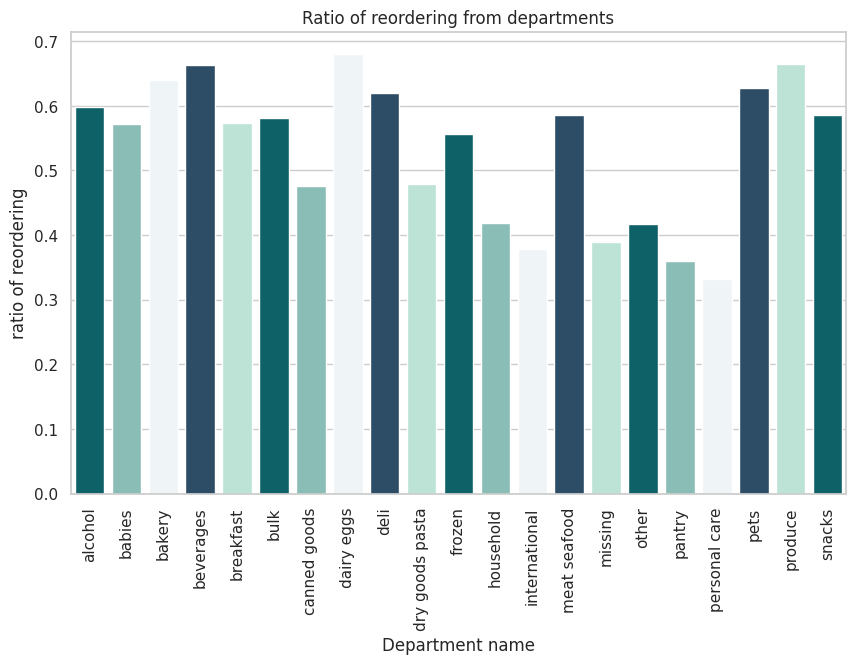

,department,reordered_ratio
7,dairy eggs,0.680849
19,produce,0.665119
3,beverages,0.663916
2,bakery,0.640543
18,pets,0.628098


In [ ]:
# Heatmap on the propability of non-new users to reorder for each day each hour
non_first_orders = order_products['order_number'] != 1
groupeddf = order_products[non_first_orders].groupby(['department']).agg({'reordered':'mean'}).reset_index().rename(columns={'reordered':'reordered_ratio'})

groupeddf = groupeddf.sort_values(by=['reordered_ratio'], ascending=False)
sns.barplot(x='department', y='reordered_ratio', data=groupeddf, palette=colors)

plt.title('Ratio of reordering from departments')
plt.ylabel('ratio of reordering')
plt.xticks(rotation=90)
plt.xlabel('Department name')
plt.show()

groupeddf.head()

#### Analyze ordering frequency of specific department across dayhours and weekdays

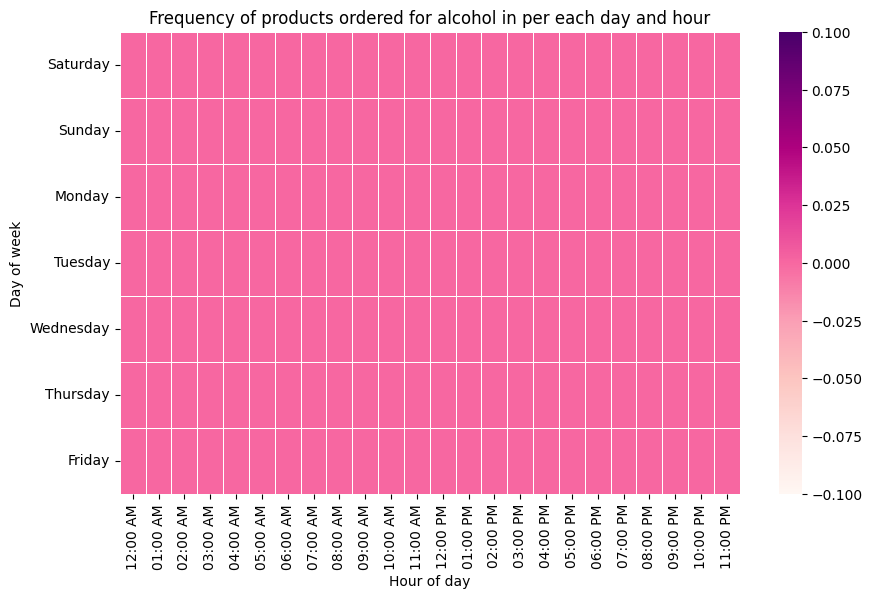

In [74]:
# Take department name as input
# dep_name = input('Enter the department name you want to generate heatmap for:')
dep_name='alcohol'
exists = dep_name in departments['department'].unique()

if (exists):
    # Heatmap of the count of orders in each day with each hour
    dep_order_products = order_products[order_products['department']==dep_name]
    groupeddf = dep_order_products.groupby(['order_dow', 'order_hour_of_day']).agg('count').reset_index().rename(columns={'order_id':'order_prods_count'})
    #heatmap_data = groupeddf.pivot('order_dow', 'order_hour_of_day', 'order_prods_count')
    heatmap_data = groupeddf.pivot_table(index='order_dow', columns='order_hour_of_day', values='order_prods_count')

    ax = sns.heatmap(data=heatmap_data, cmap="RdPu", linewidths=.5)
    plt.title('Frequency of products ordered for '+dep_name+' in per each day and hour')
    plt.ylabel('Day of week')
    plt.xlabel('Hour of day')
    plt.show()

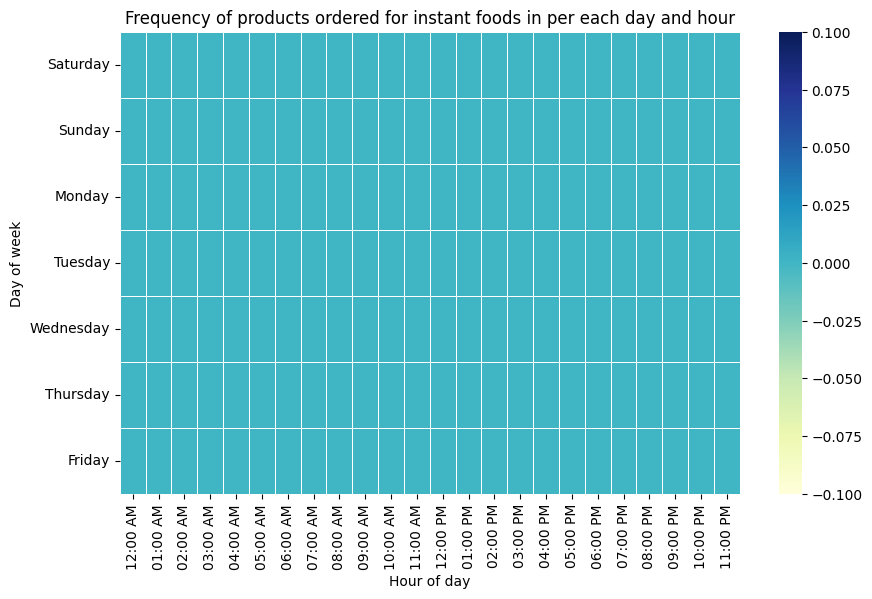

In [80]:
# Take aisle name as input
# aisle_name = input('Enter the aisle name you want to generate heatmap for:')
aisle_name = 'instant foods'
exists = aisle_name in aisles['aisle'].unique()

if (exists):
    # Heatmap of the count of orders in each day with each hour
    aisle_order_products = order_products[order_products['aisle']==aisle_name]
    groupeddf = aisle_order_products.groupby(['order_dow', 'order_hour_of_day']).agg('count').reset_index().rename(columns={'order_id':'order_prods_count'})
    heatmap_data = groupeddf.pivot(index = 'order_dow', columns = 'order_hour_of_day', values = 'order_prods_count')

    ax = sns.heatmap(data=heatmap_data, cmap="YlGnBu", linewidths=.5)
    plt.title('Frequency of products ordered for '+aisle_name+' in per each day and hour')
    plt.ylabel('Day of week')
    plt.xlabel('Hour of day')
    plt.show()

## Extracting Features For Predictive Analysis Model

### Problem Defenition
Predict whether the user will order one of his prior ordered products or not.
Primary Key is the user-product pair to predict whether will be a reorder or not.

### Features Extracted
#### User dependent Features
- Ratio of having reordered product in the user's prior orders.
- Frequency of the user buying this product.
- Frequency of the user buying products from the same aisle.
- On avg the hour the user buys this product at.
- On avg which day of week the user buys this product at.
- On avg # of days between 2 user's orders containing this product.
- On avg the add to cart order by which the user puts this product in his prior orders.

#### User independent Features
- Frequency of buying this product.
- Frequency of buying this product at the future's order hour of day.
- Frequency of buying this product on the future's order day of week.
- On avg the hour the product is most bought at.